In [1]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import pennylane as qml
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import time, os, random
import pandas as pd

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

def set_all_seeds(seed: int = 42) -> None:
    """Seed every RNG we rely on (Python, NumPy, Torch, PennyLane, CUDNN)."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    qml.numpy.random.seed(seed)

# --- End of Cell 1 ---

Running on cuda


In [2]:
# Cell 2: NARMA Data Generation Functions
def generate_narma_data(n_samples, order, seed=None):
    """Generates NARMA time-series data."""
    if seed is not None:
        np.random.seed(seed)
    u = np.random.uniform(0, 0.5, n_samples)
    y = np.zeros(n_samples)
    for t in range(order, n_samples):
        term1 = 0.3 * y[t-1]
        term2 = 0.05 * y[t-1] * np.sum(y[t-i-1] for i in range(order))
        term3 = 1.5 * u[t-order] * u[t-1]
        term4 = 0.1
        y[t] = term1 + term2 + term3 + term4
    return y.reshape(-1, 1)

def transform_narma_data(data, seq_len):
    """Transforms NARMA data into input-output pairs."""
    x, y = [], []
    for i in range(len(data) - seq_len):
        _x = data[i:(i + seq_len)]
        _y = data[i + seq_len]
        x.append(_x)
        y.append(_y)
    x = np.array(x).transpose(0, 2, 1)
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(np.array(y)).float()
    return x, y

def get_narma_dataloaders(n_samples=2000, order=10, seq_len=20, batch_size=32, train_p=0.7, val_p=0.15, seed=None):
    """Creates DataLoader objects for the NARMA task."""
    print("Generating NARMA data...")
    narma_series = generate_narma_data(n_samples, order, seed=seed)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    dataset_scaled = scaler.fit_transform(narma_series)
    x, y = transform_narma_data(dataset_scaled, seq_len)
    full_dataset = TensorDataset(x, y)

    train_end_idx = int(train_p * len(full_dataset))
    val_end_idx = int((train_p + val_p) * len(full_dataset))
    
    train_dataset = Subset(full_dataset, range(train_end_idx))
    val_dataset = Subset(full_dataset, range(train_end_idx, val_end_idx))
    test_dataset = Subset(full_dataset, range(val_end_idx, len(full_dataset)))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    print(f"Data loaded. Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")
    input_dim = (batch_size, x.shape[1], x.shape[2])
    return train_loader, val_loader, test_loader, input_dim, scaler, full_dataset, len(train_dataset), len(val_dataset)

# --- End of Cell 2 ---

In [6]:
# Cell 3: QCNN Baseline Model
class QCNN_Baseline(nn.Module):
    def __init__(self, n_qubits, circuit_depth, input_dim):
        super(QCNN_Baseline, self).__init__()
        self.n_qubits = n_qubits
        self.circuit_depth = circuit_depth
        
        # Quantum parameters
        self.conv_params = nn.Parameter(torch.randn(circuit_depth, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(circuit_depth, n_qubits // 2, 3))
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.qc = qml.QNode(self.circuit, self.dev)
        
        self.input_channels = input_dim[1]
        self.time_steps = input_dim[2]
        
        # CORRECTED: The FC layer now correctly takes the entire flattened time series as input.
        self.fc = nn.Linear(self.input_channels * self.time_steps, n_qubits)

    def circuit(self, features):
        wires = list(range(self.n_qubits))    
        qml.AngleEmbedding(features, wires=wires, rotation='Y')
        for layer in range(self.circuit_depth):
            self._apply_convolution(self.conv_params[layer], wires)
            self._apply_pooling(self.pool_params[layer], wires)
            wires = wires[::2]
        return qml.expval(qml.PauliZ(wires[-1]))

    def _apply_convolution(self, weights, wires):
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."
        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])
                
    def forward(self, x):
        batch_size, _, _ = x.size()
        
        # CORRECTED: Replaced sliding window logic with direct processing.
        # 1. Reshape the input to flatten the entire time series.
        flattened_input = x.reshape(batch_size, -1)
        
        # 2. Pass the flattened sequence through the classical FC layer.
        reduced_input = self.fc(flattened_input)
        
        # 3. Feed the result into the quantum circuit.
        output = self.qc(reduced_input).float()
        return output

# --- End of Cell 3 ---

In [7]:
# Cell 4: Training, Evaluation, and Plotting Functions
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            total_loss += loss.item()
    return total_loss / len(dataloader)
    
def predict(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return np.concatenate(all_preds), np.concatenate(all_labels)

def plot_loss(train_losses, val_losses, test_losses, filename="qcnn_loss_curve.png"):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('QCNN Baseline Training, Validation, and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    print(f"Loss curve saved to {filename}")
    plt.show()

def plot_predictions(predictions, labels, scaler, train_size, val_size, filename="qcnn_predictions.png"):
    predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1))
    labels_rescaled = scaler.inverse_transform(labels.reshape(-1, 1))
    plt.figure(figsize=(15, 6))
    plt.plot(labels_rescaled, label='Ground Truth', color='blue', alpha=0.7)
    plt.plot(predictions_rescaled, label='Predictions', color='red', linestyle='--')
    plt.axvline(x=train_size, color='g', linestyle='--', label='Train/Val Split')
    plt.axvline(x=train_size + val_size, color='m', linestyle='--', label='Val/Test Split')
    plt.title('QCNN Baseline NARMA Predictions vs Ground Truth')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    print(f"Prediction plot saved to {filename}")
    plt.show()

def save_log_to_csv(exp_name, epoch_data, timeseries_data):
    if not os.path.exists(exp_name):
        os.makedirs(exp_name)
    df_loss = pd.DataFrame(epoch_data)
    loss_csv_path = os.path.join(exp_name, "qcnn_narma_losses.csv")
    df_loss.to_csv(loss_csv_path, index=False)
    print(f"Saved epoch losses to {loss_csv_path}")
    df_timeseries = pd.DataFrame(timeseries_data)
    ts_csv_path = os.path.join(exp_name, "qcnn_narma_timeseries.csv")
    df_timeseries.to_csv(ts_csv_path, index=False)
    print(f"Saved final time series to {ts_csv_path}")
    
# --- End of Cell 4 ---

/tmp/ipykernel_204070/1649675633.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  term2 = 0.05 * y[t-1] * np.sum(y[t-i-1] for i in range(order))


Saving all outputs to directory: QCNN_NARMA_2027
Generating NARMA data...
Data loaded. Train size: 161, Val size: 34, Test size: 35
Total trainable parameters: 352


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


Epoch 1: New best model saved with validation loss: 0.0961
Epoch: 01 | Time: 0m 0s
	Train Loss: 0.1287 | Val. Loss: 0.0961 | Test Loss: 0.0704


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.93it/s]


Epoch: 02 | Time: 0m 0s
	Train Loss: 0.0996 | Val. Loss: 0.1039 | Test Loss: 0.0902


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.40it/s]


Epoch 3: New best model saved with validation loss: 0.0960
Epoch: 03 | Time: 0m 0s
	Train Loss: 0.0964 | Val. Loss: 0.0960 | Test Loss: 0.0782


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.11it/s]


Epoch 4: New best model saved with validation loss: 0.0895
Epoch: 04 | Time: 0m 0s
	Train Loss: 0.0861 | Val. Loss: 0.0895 | Test Loss: 0.0637


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


Epoch 5: New best model saved with validation loss: 0.0885
Epoch: 05 | Time: 0m 0s
	Train Loss: 0.0809 | Val. Loss: 0.0885 | Test Loss: 0.0596


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.05it/s]


Epoch 6: New best model saved with validation loss: 0.0871
Epoch: 06 | Time: 0m 0s
	Train Loss: 0.0769 | Val. Loss: 0.0871 | Test Loss: 0.0641


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


Epoch 7: New best model saved with validation loss: 0.0870
Epoch: 07 | Time: 0m 0s
	Train Loss: 0.0745 | Val. Loss: 0.0870 | Test Loss: 0.0673


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.06it/s]


Epoch 8: New best model saved with validation loss: 0.0868
Epoch: 08 | Time: 0m 0s
	Train Loss: 0.0720 | Val. Loss: 0.0868 | Test Loss: 0.0633


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.22it/s]


Epoch 9: New best model saved with validation loss: 0.0867
Epoch: 09 | Time: 0m 0s
	Train Loss: 0.0672 | Val. Loss: 0.0867 | Test Loss: 0.0625


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch 10: New best model saved with validation loss: 0.0855
Epoch: 10 | Time: 0m 0s
	Train Loss: 0.0649 | Val. Loss: 0.0855 | Test Loss: 0.0638


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.12it/s]


Epoch 11: New best model saved with validation loss: 0.0848
Epoch: 11 | Time: 0m 0s
	Train Loss: 0.0660 | Val. Loss: 0.0848 | Test Loss: 0.0647


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 22.25it/s]


Epoch 12: New best model saved with validation loss: 0.0834
Epoch: 12 | Time: 0m 0s
	Train Loss: 0.0649 | Val. Loss: 0.0834 | Test Loss: 0.0658


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.86it/s]


Epoch 13: New best model saved with validation loss: 0.0828
Epoch: 13 | Time: 0m 0s
	Train Loss: 0.0641 | Val. Loss: 0.0828 | Test Loss: 0.0641


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.93it/s]


Epoch 14: New best model saved with validation loss: 0.0813
Epoch: 14 | Time: 0m 0s
	Train Loss: 0.0623 | Val. Loss: 0.0813 | Test Loss: 0.0656


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.23it/s]


Epoch 15: New best model saved with validation loss: 0.0798
Epoch: 15 | Time: 0m 0s
	Train Loss: 0.0613 | Val. Loss: 0.0798 | Test Loss: 0.0652


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.47it/s]


Epoch 16: New best model saved with validation loss: 0.0786
Epoch: 16 | Time: 0m 0s
	Train Loss: 0.0602 | Val. Loss: 0.0786 | Test Loss: 0.0637


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.11it/s]


Epoch 17: New best model saved with validation loss: 0.0779
Epoch: 17 | Time: 0m 0s
	Train Loss: 0.0594 | Val. Loss: 0.0779 | Test Loss: 0.0637


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.63it/s]


Epoch 18: New best model saved with validation loss: 0.0779
Epoch: 18 | Time: 0m 0s
	Train Loss: 0.0590 | Val. Loss: 0.0779 | Test Loss: 0.0642


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.25it/s]


Epoch 19: New best model saved with validation loss: 0.0767
Epoch: 19 | Time: 0m 0s
	Train Loss: 0.0583 | Val. Loss: 0.0767 | Test Loss: 0.0672


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.10it/s]


Epoch 20: New best model saved with validation loss: 0.0761
Epoch: 20 | Time: 0m 0s
	Train Loss: 0.0573 | Val. Loss: 0.0761 | Test Loss: 0.0643


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.33it/s]


Epoch 21: New best model saved with validation loss: 0.0756
Epoch: 21 | Time: 0m 0s
	Train Loss: 0.0584 | Val. Loss: 0.0756 | Test Loss: 0.0628


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.48it/s]


Epoch: 22 | Time: 0m 0s
	Train Loss: 0.0585 | Val. Loss: 0.0759 | Test Loss: 0.0705


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.69it/s]


Epoch 23: New best model saved with validation loss: 0.0736
Epoch: 23 | Time: 0m 0s
	Train Loss: 0.0563 | Val. Loss: 0.0736 | Test Loss: 0.0636


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.85it/s]


Epoch: 24 | Time: 0m 0s
	Train Loss: 0.0568 | Val. Loss: 0.0740 | Test Loss: 0.0631


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.21it/s]


Epoch: 25 | Time: 0m 0s
	Train Loss: 0.0559 | Val. Loss: 0.0740 | Test Loss: 0.0674


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.32it/s]


Epoch: 26 | Time: 0m 0s
	Train Loss: 0.0548 | Val. Loss: 0.0737 | Test Loss: 0.0652


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.48it/s]


Epoch: 27 | Time: 0m 0s
	Train Loss: 0.0541 | Val. Loss: 0.0741 | Test Loss: 0.0629


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.14it/s]


Epoch 28: New best model saved with validation loss: 0.0720
Epoch: 28 | Time: 0m 0s
	Train Loss: 0.0546 | Val. Loss: 0.0720 | Test Loss: 0.0663


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.06it/s]


Epoch 29: New best model saved with validation loss: 0.0712
Epoch: 29 | Time: 0m 0s
	Train Loss: 0.0538 | Val. Loss: 0.0712 | Test Loss: 0.0640


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.77it/s]


Epoch: 30 | Time: 0m 0s
	Train Loss: 0.0533 | Val. Loss: 0.0720 | Test Loss: 0.0636


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.44it/s]


Epoch: 31 | Time: 0m 0s
	Train Loss: 0.0537 | Val. Loss: 0.0714 | Test Loss: 0.0645


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.29it/s]


Epoch 32: New best model saved with validation loss: 0.0705
Epoch: 32 | Time: 0m 0s
	Train Loss: 0.0526 | Val. Loss: 0.0705 | Test Loss: 0.0643


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.06it/s]


Epoch: 33 | Time: 0m 0s
	Train Loss: 0.0526 | Val. Loss: 0.0705 | Test Loss: 0.0642


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.81it/s]


Epoch: 34 | Time: 0m 0s
	Train Loss: 0.0525 | Val. Loss: 0.0717 | Test Loss: 0.0645


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.73it/s]


Epoch: 35 | Time: 0m 0s
	Train Loss: 0.0507 | Val. Loss: 0.0718 | Test Loss: 0.0649


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.49it/s]


Epoch: 36 | Time: 0m 0s
	Train Loss: 0.0520 | Val. Loss: 0.0722 | Test Loss: 0.0645


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.08it/s]


Epoch: 37 | Time: 0m 0s
	Train Loss: 0.0522 | Val. Loss: 0.0714 | Test Loss: 0.0663


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.31it/s]


Epoch 38: New best model saved with validation loss: 0.0704
Epoch: 38 | Time: 0m 0s
	Train Loss: 0.0514 | Val. Loss: 0.0704 | Test Loss: 0.0638


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.50it/s]


Epoch: 39 | Time: 0m 0s
	Train Loss: 0.0521 | Val. Loss: 0.0711 | Test Loss: 0.0645


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.19it/s]


Epoch: 40 | Time: 0m 0s
	Train Loss: 0.0479 | Val. Loss: 0.0713 | Test Loss: 0.0677


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.51it/s]


Epoch: 41 | Time: 0m 0s
	Train Loss: 0.0513 | Val. Loss: 0.0715 | Test Loss: 0.0653


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.16it/s]


Epoch: 42 | Time: 0m 0s
	Train Loss: 0.0512 | Val. Loss: 0.0715 | Test Loss: 0.0641


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.62it/s]


Epoch: 43 | Time: 0m 0s
	Train Loss: 0.0506 | Val. Loss: 0.0710 | Test Loss: 0.0677


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.00it/s]


Epoch 44: New best model saved with validation loss: 0.0703
Epoch: 44 | Time: 0m 0s
	Train Loss: 0.0512 | Val. Loss: 0.0703 | Test Loss: 0.0656


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.98it/s]


Epoch: 45 | Time: 0m 0s
	Train Loss: 0.0509 | Val. Loss: 0.0716 | Test Loss: 0.0647


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.60it/s]


Epoch: 46 | Time: 0m 0s
	Train Loss: 0.0506 | Val. Loss: 0.0716 | Test Loss: 0.0656


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.49it/s]


Epoch: 47 | Time: 0m 0s
	Train Loss: 0.0500 | Val. Loss: 0.0709 | Test Loss: 0.0663


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.06it/s]


Epoch: 48 | Time: 0m 0s
	Train Loss: 0.0504 | Val. Loss: 0.0714 | Test Loss: 0.0673


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.95it/s]


Epoch: 49 | Time: 0m 0s
	Train Loss: 0.0497 | Val. Loss: 0.0710 | Test Loss: 0.0650


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.87it/s]


Epoch: 50 | Time: 0m 0s
	Train Loss: 0.0503 | Val. Loss: 0.0715 | Test Loss: 0.0661
Loss curve saved to QCNN_NARMA_2027/qcnn_loss_curve.png


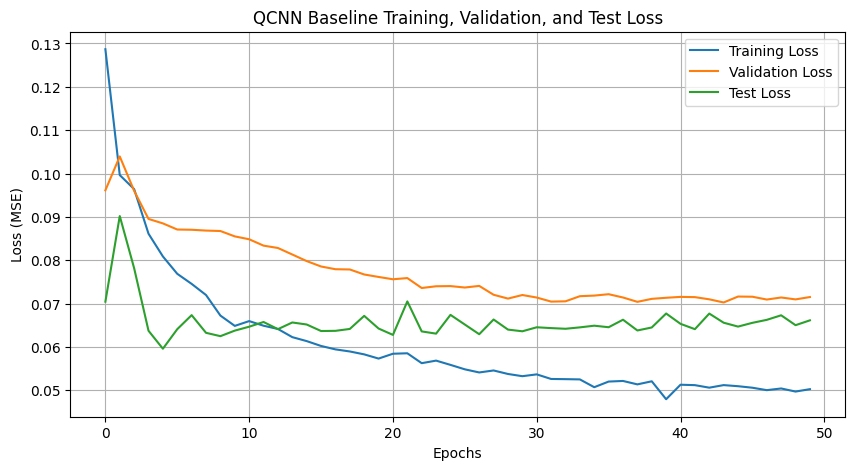


Generating predictions for the entire dataset...
Prediction plot saved to QCNN_NARMA_2027/qcnn_predictions.png


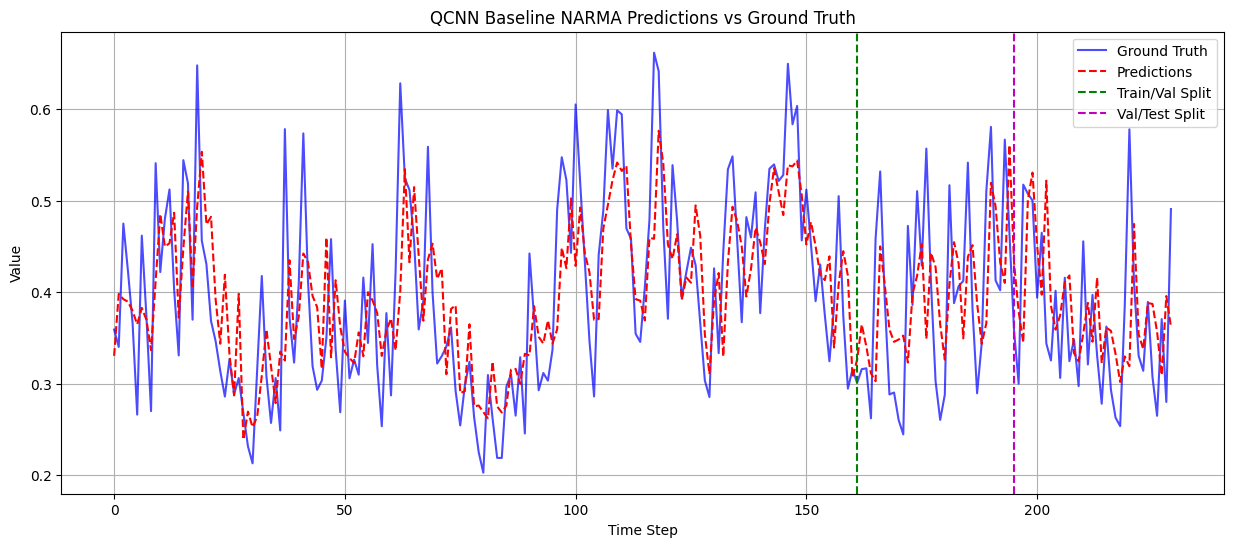

Saved epoch losses to QCNN_NARMA_2027/qcnn_narma_losses.csv
Saved final time series to QCNN_NARMA_2027/qcnn_narma_timeseries.csv


In [12]:
# Cell 5: Main Execution Block
# Hyperparameters
SEED = 2027
EXP_NAME = f"QCNN_NARMA_{SEED}"
N_QUBITS = 8
CIRCUIT_DEPTH = 2
N_SAMPLES = 240
ORDER = 10
SEQ_LEN = 10
BATCH_SIZE = 32
EPOCHS = 50

# Set seed
set_all_seeds(seed=SEED)

# Create the output directory at the start ---
os.makedirs(EXP_NAME, exist_ok=True)
print(f"Saving all outputs to directory: {EXP_NAME}")

# Load data
train_loader, val_loader, test_loader, input_dim, scaler, full_dataset, train_size, val_size = get_narma_dataloaders(
    n_samples=N_SAMPLES, order=ORDER, seq_len=SEQ_LEN, batch_size=BATCH_SIZE, seed=SEED
)

# CORRECTED: Initialize the new baseline model
model = QCNN_Baseline(
    n_qubits=N_QUBITS,
    circuit_depth=CIRCUIT_DEPTH,
    input_dim=input_dim
).to(device)

# --- Add this snippet to count parameters ---
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")
# -----------------------------------------

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4, eps=1e-8)

# Define the model path inside the new directory ---
model_path = os.path.join(EXP_NAME, 'qcnn_narma_best_model.pth')

# Training loop
train_losses, val_losses, test_losses = [], [], []
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.time()
    
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)
    test_loss = evaluate(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    end_time = time.time()
    epoch_mins = int((end_time - start_time) / 60)
    epoch_secs = int((end_time - start_time) - (epoch_mins * 60))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_path)
        print(f"Epoch {epoch+1}: New best model saved with validation loss: {val_loss:.4f}")

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.4f} | Val. Loss: {val_loss:.4f} | Test Loss: {test_loss:.4f}')

# Load best model for final predictions
model.load_state_dict(torch.load(model_path))

# Define plot paths and pass them to the functions ---
loss_plot_path = os.path.join(EXP_NAME, "qcnn_loss_curve.png")
pred_plot_path = os.path.join(EXP_NAME, "qcnn_predictions.png")

# Plotting and Logging
plot_loss(train_losses, val_losses, test_losses, filename=loss_plot_path)

print("\nGenerating predictions for the entire dataset...")
full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
predictions, labels = predict(model, full_loader)
plot_predictions(predictions, labels, scaler, train_size, val_size, filename=pred_plot_path)

# Save logs to CSV
epoch_log_data = {
    'epoch': list(range(1, EPOCHS + 1)),
    'train_loss': train_losses,
    'validation_loss': val_losses,
    'test_loss': test_losses
}
timeseries_log_data = {
    'prediction': predictions.flatten(),
    'ground_truth': labels.flatten()
}
save_log_to_csv(EXP_NAME, epoch_log_data, timeseries_log_data)

# --- End of Cell 5 ---